In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator



gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics

# !pip3 install keras-tuner --upgrade
# !pip3 install autokeras
import kerastuner as kt
import autokeras as ak

#Plot's Making  Packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib import font_manager


# Import local libraries
import numpy as np
import h5py
import time
import pandas as pd
import importlib
from scipy import interpolate
import os
from tqdm import tqdm 

import logging

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

os.environ['NUMEXPR_MAX_THREADS'] = '64'
os.environ['NUMEXPR_NUM_THREADS'] = '64'

print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

%config InlineBackend. figure_format = 'retina'

1 Physical GPUs, 1 Logical GPU
Tensorflow Version is 2.4.1
Keras Version is 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3946736619811626747
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1048576000
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 13202775868177164483
physical_device_desc: "device: 0, name: A100-SXM-80GB, pci bus id: 0000:48:00.0, compute capability: 8.0"
]
Mon Dec  6 12:20:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|=============================

In [4]:
filepath = "./"+str("herwig_ang")+"_KFold/CNN_"+str("herwig_ang")+"_Models_"+str(int(300))+str(int(500))+"/" + str("herwig_ang") + "_CNN_"+str(0)+ ".h5"
if os.path.exists(filepath):
#                     CNN_Model_A1[model] = load_model(filepath)

    model_CNN = load_model(filepath)
model_CNN.summary()

Model: "Model_CNN_herwig_ang_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 32, 36, 36)        2432      
_________________________________________________________________
jet_MaxPooling_1 (MaxPooling (None, 16, 18, 36)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 64, 14, 32)        25664     
_________________________________________________________________
jet_MaxPooling_2 (MaxPooling (None, 64, 7, 16)         0         
_________________________________________________________________
jet_flatten (Flatten)        (None, 7168)              0         
_________________________________________________________________
jet_dense_1 (Dense)          (None, 300)               2150700   
_________________________________________________________________
jet_dense_2 (Dense)          (None, 150)    

In [2]:
def Loading_Data(data_source, datadict, start=0, stop=20000):
    x_jet, target = [], []

    time.sleep(0.5)
    for k in tqdm(range(start,len(data_source))):
        x_jet_path = savepath + "Image_Directory/"+ data_source["JetImage"].iloc[k]
        x_jet_tmp = np.load(x_jet_path)["jet_image"]
        if np.isnan(x_jet_tmp).any() == True:
            continue 

        target.append(data_source["Y"].iloc[k])
        x_jet_tmp = np.divide((x_jet_tmp - Norm_dict[datadict][0]), (np.sqrt(Norm_dict[datadict][1])+1e-5))#[0].reshape(1,40,40)
        x_jet.append(x_jet_tmp)


        if k == stop:
            break

    return np.asarray(x_jet), np.asarray(target)

In [89]:
%%time
HOMEPATH = "/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/"
Data_High_Level_Features_path =  HOMEPATH + "Data_High_Level_Features/"
savepath = HOMEPATH + "Data_ML/"



data_dict ={
            "herwig_ang" : [0,0],
            "pythia_def" : [0,0],
            "pythia_vin" : [0,0],
            "pythia_dip" : [0,0],
#             "sherpa_def" : [0,0],
          }  

Norm_dict ={
            "herwig_ang" : [0,0],
            "pythia_def" : [0,0],
            "pythia_vin" : [0,0],
            "pythia_dip" : [0,0],
#             "sherpa_def" : [0,0],
          }  

data_train = {
            "herwig_ang_train" : 0,
            "pythia_def_train" : 0,
            "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
#             "sherpa_def_train" : 0
            }  


CNN_Model_A1 = {
      "herwig_ang" : 0,
      "pythia_def" : 0, 
      "pythia_vin" : 0, 
      "pythia_dip" : 0, 
#       "sherpa_def" : 0,
    }

       


for j, element in enumerate(data_dict):
    data_dict[element][0] = pd.read_csv(savepath + str(element) + "_H_dict.csv")
    data_dict[element][1] = pd.read_csv(savepath + str(element) + "_QCD_dict.csv")
#         logging.info(len(data_dict[element][0]),len(data_dict[element][1]))

for j, element in enumerate(Norm_dict):
    average_H = np.load(savepath + "average" + "_" + str(element) + "_H.npy")
    variance_H = np.load(savepath + "variance" + "_" + str(element) + "_H.npy")
    average_QCD = np.load(savepath + "average" + "_" + str(element) + "_QCD.npy")
    variance_QCD = np.load(savepath + "variance" + "_" + str(element) + "_QCD.npy")
    length_H = len(data_dict[element][0])
    length_QCD = len(data_dict[element][1])

    Norm_dict[element][0] = (average_H*length_H + average_QCD*length_QCD)/(length_H+length_QCD)
    Norm_dict[element][1] =  variance_H + variance_QCD

for j, (traindata, datadict) in enumerate(zip(data_train, data_dict)):

    """
    Pt Range Study
    """
#         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
    for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):

        train_data_path = HOMEPATH + "Notebook/KFold_CNN/" + str(traindata) + ".csv"
        if os.path.exists(train_data_path):
            tmp = pd.read_csv(train_data_path)
        else:
            raise ValueError("Pleas check training data path !!")

        tmp = tmp[(tmp["PTJ_0"] >= pt_min)  & (tmp["PTJ_0"] < pt_max)]
        tmp = tmp[(tmp["MJ_0"] >= 110)  & (tmp["MJ_0"] < 160)]
        data_train[traindata] = shuffle(tmp)#[:30000]

        H_tmp = data_train[traindata][data_train[traindata]["target"] == 1]
        QCD_tmp = data_train[traindata][data_train[traindata]["target"] == 0]

        H_dict = data_dict[datadict][0].iloc[H_tmp["index"].values]
        QCD_dict = data_dict[datadict][1].iloc[QCD_tmp["index"].values]

        data_train[traindata] = pd.concat([H_dict, QCD_dict], ignore_index=True, axis=0,join='inner')
        data_train[traindata] = shuffle(data_train[traindata])


        logging.info("START===========================================START")
        logging.info("\r") 
        logging.info("All Files are loaded!")
        logging.info("pt min: {} , pt max: {}".format(pt_min, pt_max))
        logging.info("\r")
        logging.info("H jet : QCD jet = 1 : 1")
        logging.info("{}, # of H jet: {}".format(traindata, len(H_dict)))
        logging.info("{}, # of QCD jet: {}".format(traindata, len(QCD_dict)))
        train = len(data_train[traindata])
        logging.info("{:^8}{:^15}".format("Train #",train))


        kf = KFold(n_splits = 50)
        # kf = GroupKFold(n_splits = 100)
#             skf = StratifiedKFold(n_splits = 2, random_state = 7, shuffle = True) 

        x_jet, target = Loading_Data(data_train[traindata], datadict, start=0, stop= len(data_train[traindata]))


        logging.info("CNN Model: {}  Test Data: {}".format(model, traindata))
        time.sleep(0.5)
        for model_index, (train_index, val_index) in enumerate(kf.split(target)):
            ticks_1 = time.time()

            for i, model in enumerate(CNN_Model_A1): 
#                 logging.info("CNN Model: {}".format(model))

                x_train_jet, target_train = x_jet[train_index], target[train_index]
                x_val_jet, target_val = x_jet[val_index], target[val_index]


                Performance_Frame = {
                "AUC" : [0],
                "max_sig" : [0],
                "r05" : [0],
                "time": [0]
                }


                filepath = "./"+str(model)+"_KFold/CNN_"+str(model)+"_Models_"+str(int(pt_min))+str(int(pt_max))+"/" + str(model) + "_CNN_"+str(model_index)+ ".h5"
                if os.path.exists(filepath):
    #                     CNN_Model_A1[model] = load_model(filepath)

                    model_CNN = load_model(filepath)

                    prediction_test =  model_CNN.predict(np.asarray(x_val_jet))
                    discriminator_test = prediction_test
                    discriminator_test = discriminator_test/(max(discriminator_test))

                    Performance_Frame["AUC"][0] = metrics.roc_auc_score(np.asarray(target_val), discriminator_test)
                    FalsePositiveFull, TruePositiveFull, _ = metrics.roc_curve(np.asarray(target_val), discriminator_test)
                    tmp = np.where(FalsePositiveFull != 0)
                    Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
                    tmp = np.where(TruePositiveFull >= 0.5)
                    Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]

                    Performance_Frame["time"][0] = (time.time() - ticks_1)/60.

                    dataframe = pd.DataFrame(Performance_Frame)



                    csvdata_path = "./"+str(model)+"_KFold/CNN_"+str(model)+"_Performance_Table_to_"+str(traindata)+"_"+str(pt_min)+str(pt_max)+".csv"
                    if os.path.exists(csvdata_path):
                        save_to_csvdata = pd.read_csv(csvdata_path)
                        DATA = pd.concat([save_to_csvdata, dataframe], ignore_index=True, axis=0,join='inner')
                        DATA.to_csv(csvdata_path, index = 0)

                    else:
                        dataframe.to_csv(csvdata_path, index = 0)
                    
                    h5_path = "./"+str(model)+"_KFold/CNN_"+str(model)+"_Performance_Table_to_"+str(traindata)+"_"+str(pt_min)+str(pt_max)+".h5"
                    if os.path.exists(h5_path):
                        save_to_hf = h5py.File(h5_path, 'r+')
                        save_to_hf.create_dataset("prediction_test_" + str(model_index), data=prediction_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("discriminator_test_" + str(model_index), data=discriminator_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("FalsePositiveFull_" + str(model_index), data=FalsePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("TruePositiveFull_" + str(model_index), data=TruePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("target_val_" + str(model_index), data=target_val, compression="gzip", compression_opts=5)
                        save_to_hf.close()

                    else:
                        save_to_hf = h5py.File(h5_path, 'w')
                        save_to_hf.create_dataset("prediction_test_" + str(model_index), data=prediction_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("discriminator_test_" + str(model_index), data=discriminator_test, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("FalsePositiveFull_" + str(model_index), data=FalsePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("TruePositiveFull_" + str(model_index), data=TruePositiveFull, compression="gzip", compression_opts=5)
                        save_to_hf.create_dataset("target_val_" + str(model_index), data=target_val, compression="gzip", compression_opts=5)
                        save_to_hf.close()


                else:
                    raise ValueError("Pleas check model path !!")


        logging.info("There are {} events for each test.".format(len(target_val)))
        logging.info("{} CNN models apply on {} is finished!!".format(model,traindata))
        logging.info("END===========================================END")
        logging.info("\n")


logging.info("\n")
logging.info("\n")


INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:herwig_ang_train, # of H jet: 153728
INFO:root:herwig_ang_train, # of QCD jet: 153728
INFO:root:Train #     307456     
100%|██████████| 307456/307456 [06:00<00:00, 853.97it/s]
INFO:root:CNN Model: pythia_dip  Test Data: herwig_ang_train
INFO:root:There are 6149 events for each test.
INFO:root:pythia_dip CNN models apply on herwig_ang_train is finished!!
INFO:root:END===========================================END
INFO:root:

INFO:root:START===========================================START
INFO:root:
INFO:root:All Files are loaded!
INFO:root:pt min: 300 , pt max: 500
INFO:root:
INFO:root:H jet : QCD jet = 1 : 1
INFO:root:pythia_def_train, # of H jet: 153728
INFO:root:pythia_def_train, # of QCD jet: 153728
INFO:root:Train #     307456     
100%|██████████| 307456/307456 [06:01<00:00, 849.45it/s

CPU times: user 32min 45s, sys: 45min 17s, total: 1h 18min 3s
Wall time: 1h 24min 6s


In [3]:
%%time
CNN_Model_A1 = {
              "herwig_ang" : 0,
#               "pythia_def" : 0, 
#               "pythia_vin" : 0, 
#               "pythia_dip" : 0, 
#               "sherpa_def" : 0,
            }

Performance_Frame = {
            "herwig_ang_train" : 0,
            "pythia_def_train" : 0,
            "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
        }  

        
# index=["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average", "STD"]

for i, model in enumerate(CNN_Model_A1): 
    logging.info("CNN Model: {} ".format(model))
    

    
    for j, element in enumerate(Performance_Frame): 
        
        Performance = {
                    "AUC" : [0,0,0,0,0,0],
                    "AUC std" : [0,0,0,0,0,0],
                    "max_sig" : [0,0,0,0,0,0],
                    "max_sig std" : [0,0,0,0,0,0],
                    "r05" : [0,0,0,0,0,0],
                    "r05 std" : [0,0,0,0,0,0],
                    "time": [0,0,0,0,0,0],
                    "time std" : [0,0,0,0,0,0],
                    }

    
#         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):
            Performance_Table = pd.read_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
#             Performance_Table = pd.read_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
            
            logging.info(len(Performance_Table))

            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] <= 0.7].index, inplace=True)
            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] == 1].index, inplace=True)
            Performance["AUC"][k] = Performance_Table["AUC"].mean()
            Performance["AUC std"][k] = Performance_Table["AUC"].std()
            Performance["max_sig"][k] = Performance_Table["max_sig"].mean()
            Performance["max_sig std"][k] = Performance_Table["max_sig"].std()
            Performance["r05"][k] = Performance_Table["r05"].mean()
            Performance["r05 std"][k] = Performance_Table["r05"].std()
            Performance["time"][k] = Performance_Table["time"].mean()
            Performance["time std"][k] = Performance_Table["time"].std()



#         Performance_Frame[element] = pd.DataFrame(Performance,
#                      index=["pt300400","pt400500","pt500600","pt600700","pt700800","pt800900"]
#                     )
        
        Performance_Frame[element] = pd.DataFrame(Performance,
                     index=["pt3001100","null","null","null","null","null"]
                    )

INFO:root:CNN Model: herwig_ang 
INFO:root:50
INFO:root:50
INFO:root:50
INFO:root:50


CPU times: user 38.3 ms, sys: 4.08 ms, total: 42.4 ms
Wall time: 46.9 ms


In [4]:
Performance_Frame["herwig_ang_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.871354,0.004559,2.146158,0.375573,15.621107,1.329219,0.073619,0.009565
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
Performance_Frame["pythia_def_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.884292,0.004734,2.288254,0.266671,17.787523,1.505778,0.078128,0.009809
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
Performance_Frame["pythia_vin_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.904968,0.003529,3.599833,0.765651,28.679416,2.672548,0.07088,0.007192
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [7]:
Performance_Frame["pythia_dip_train"]

,AUC,AUC std,max_sig,max_sig std,r05,r05 std,time,time std
pt3001100,0.902763,0.003457,3.450304,0.772632,26.29963,2.516694,0.073474,0.006458
null,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
null,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [8]:
metric = "AUC"

print(np.mean([Performance_Frame["herwig_ang_train"][metric],Performance_Frame["pythia_def_train"][metric],Performance_Frame["pythia_vin_train"][metric],Performance_Frame["pythia_dip_train"][metric]], axis=0))
print(np.std([Performance_Frame["herwig_ang_train"][metric],Performance_Frame["pythia_def_train"][metric],Performance_Frame["pythia_vin_train"][metric],Performance_Frame["pythia_dip_train"][metric]], axis=0))



[0.89084423 0.         0.         0.         0.         0.        ]
[0.01382318 0.         0.         0.         0.         0.        ]


In [119]:
%%time
CNN_Model_A1 = {
              "herwig_ang" : 0,
              "pythia_def" : 0, 
              "pythia_vin" : 0, 
              "pythia_dip" : 0, 
#               "sherpa_def" : 0,
            }

Performance_Frame = {
            "herwig_ang_train" : 0,
            "pythia_def_train" : 0,
            "pythia_vin_train" : 0,
            "pythia_dip_train" : 0,
        }  

        
# index=["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average", "STD"]

        
Performance_Summary = {
            "row1" : [0,0,0,0],
            "row2" : [0,0,0,0],
            "row3" : [0,0,0,0],
            "row4" : [0,0,0,0],
            "row5" : [0,0,0,0],
            }


    
for i, element in enumerate(Performance_Frame): 
    logging.info("test on {}".format(element))
        
    for j, model in enumerate(CNN_Model_A1): 
        logging.info("CNN Model: {} ".format(model))
        
        Performance = {
                    "AUC" : [0,0,0,0,0,0],
                    "AUC std" : [0,0,0,0,0,0],
                    "max_sig" : [0,0,0,0,0,0],
                    "max_sig std" : [0,0,0,0,0,0],
                    "r05" : [0,0,0,0,0,0],
                    "r05 std" : [0,0,0,0,0,0],
                    "time": [0,0,0,0,0,0],
                    "time std" : [0,0,0,0,0,0],
                    }

    
#         for k, (pt_min, pt_max) in  enumerate(zip([300,400,500,600,700,800],[400,500,600,700,800,900])):
        for k, (pt_min, pt_max) in  enumerate(zip([300],[500])):
            Performance_Table = pd.read_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
#             Performance_Table = pd.read_csv("./"+str(model)+"_KFold/CNN_"+str(model)+"_Performance_Table_to_"+str(element)+"_"+str(pt_min)+str(pt_max)+".csv")
            
            logging.info(len(Performance_Table))

            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] <= 0.7].index, inplace=True)
            Performance_Table.drop(Performance_Table[Performance_Table["AUC"] == 1].index, inplace=True)
            Performance["AUC"][k] = Performance_Table["AUC"].mean()
            Performance["AUC std"][k] = Performance_Table["AUC"].std()
            Performance["max_sig"][k] = Performance_Table["max_sig"].mean()
            Performance["max_sig std"][k] = Performance_Table["max_sig"].std()
            Performance["r05"][k] = Performance_Table["r05"].mean()
            Performance["r05 std"][k] = Performance_Table["r05"].std()
            Performance["time"][k] = Performance_Table["time"].mean()
            Performance["time std"][k] = Performance_Table["time"].std()



#         Performance_Frame[element] = pd.DataFrame(Performance,
#                      index=["pt300400","pt400500","pt500600","pt600700","pt700800","pt800900"]
#                     )
        
        CNN_Model_A1[model] = pd.DataFrame(Performance,
                     index=["pt3001100","null","null","null","null","null"]
                    )
        
        
    metric = "r05"
    for l, (row, model) in enumerate(zip(Performance_Summary,CNN_Model_A1)): 
            Performance_Summary[row][i] = "${:.2f}\pm{:.2f}$".format(CNN_Model_A1[model][metric][0],CNN_Model_A1[model][metric + " std"][0])
            
    ave = np.mean([CNN_Model_A1["herwig_ang"][metric],CNN_Model_A1["pythia_def"][metric],CNN_Model_A1["pythia_vin"][metric],CNN_Model_A1["pythia_dip"][metric]], axis=0)
    std = np.std([CNN_Model_A1["herwig_ang"][metric],CNN_Model_A1["pythia_def"][metric],CNN_Model_A1["pythia_vin"][metric],CNN_Model_A1["pythia_dip"][metric]], axis=0)
    
    Performance_Summary["row5"][i] = "${:.2f}\pm{:.2f}$".format(ave[0],std[0])

    

INFO:root:test on herwig_ang_train
INFO:root:CNN Model: herwig_ang 
INFO:root:50
INFO:root:CNN Model: pythia_def 
INFO:root:50
INFO:root:CNN Model: pythia_vin 
INFO:root:50
INFO:root:CNN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_def_train
INFO:root:CNN Model: herwig_ang 
INFO:root:50
INFO:root:CNN Model: pythia_def 
INFO:root:50
INFO:root:CNN Model: pythia_vin 
INFO:root:50
INFO:root:CNN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_vin_train
INFO:root:CNN Model: herwig_ang 
INFO:root:50
INFO:root:CNN Model: pythia_def 
INFO:root:50
INFO:root:CNN Model: pythia_vin 
INFO:root:50
INFO:root:CNN Model: pythia_dip 
INFO:root:50
INFO:root:test on pythia_dip_train
INFO:root:CNN Model: herwig_ang 
INFO:root:50
INFO:root:CNN Model: pythia_def 
INFO:root:50
INFO:root:CNN Model: pythia_vin 
INFO:root:50
INFO:root:CNN Model: pythia_dip 
INFO:root:50


CPU times: user 121 ms, sys: 6.42 ms, total: 127 ms
Wall time: 119 ms


In [121]:
# Format for latex
NAME = ["Herwig Angular", "Pythia Default", "Pythia Vincia", "Pythia Dipole", "Average $\pm$ Std."]
for (element, name) in zip(Performance_Summary, NAME):
    print("\\textbf{"+str(name)+"}","& {} & {} & {} & {}".format(Performance_Summary[element][0],Performance_Summary[element][1],Performance_Summary[element][2],Performance_Summary[element][3]))
    
    
    
    

\textbf{Herwig Angular} & $15.62\pm1.33$ & $17.79\pm1.51$ & $28.68\pm2.67$ & $26.30\pm2.52$
\textbf{Pythia Default} & $14.89\pm1.16$ & $19.34\pm1.63$ & $29.92\pm2.89$ & $27.47\pm2.65$
\textbf{Pythia Vincia} & $15.31\pm1.23$ & $18.96\pm1.55$ & $31.44\pm3.18$ & $28.29\pm2.45$
\textbf{Pythia Dipole} & $15.03\pm1.16$ & $18.63\pm1.49$ & $29.95\pm2.63$ & $27.93\pm2.61$
\textbf{Average $\pm$ Std.} & $15.21\pm0.28$ & $18.68\pm0.57$ & $30.00\pm0.98$ & $27.50\pm0.75$


In [103]:
# metric = "AUC"

# ave = np.mean([CNN_Model_A1["herwig_ang"][metric],CNN_Model_A1["pythia_def"][metric],CNN_Model_A1["pythia_vin"][metric],CNN_Model_A1["pythia_dip"][metric]], axis=0)
# std = np.std([CNN_Model_A1["herwig_ang"][metric],CNN_Model_A1["pythia_def"][metric],CNN_Model_A1["pythia_vin"][metric],CNN_Model_A1["pythia_dip"][metric]], axis=0)



# print("${:.2f}\pm{:.4f}$".format(CNN_Model_A1["herwig_ang"][metric][0],CNN_Model_A1["herwig_ang"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(CNN_Model_A1["pythia_def"][metric][0],CNN_Model_A1["pythia_def"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(CNN_Model_A1["pythia_vin"][metric][0],CNN_Model_A1["pythia_vin"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(CNN_Model_A1["pythia_dip"][metric][0],CNN_Model_A1["pythia_dip"][metric + " std"][0]))
# print("${:.2f}\pm{:.4f}$".format(ave[0],std[0]))


$0.90\pm0.0035$
$0.91\pm0.0033$
$0.91\pm0.0032$
$0.91\pm0.0035$
$0.91\pm0.0020$


## ROC Curves

INFO:root:CNN Model: pythia_dip
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:94: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlie

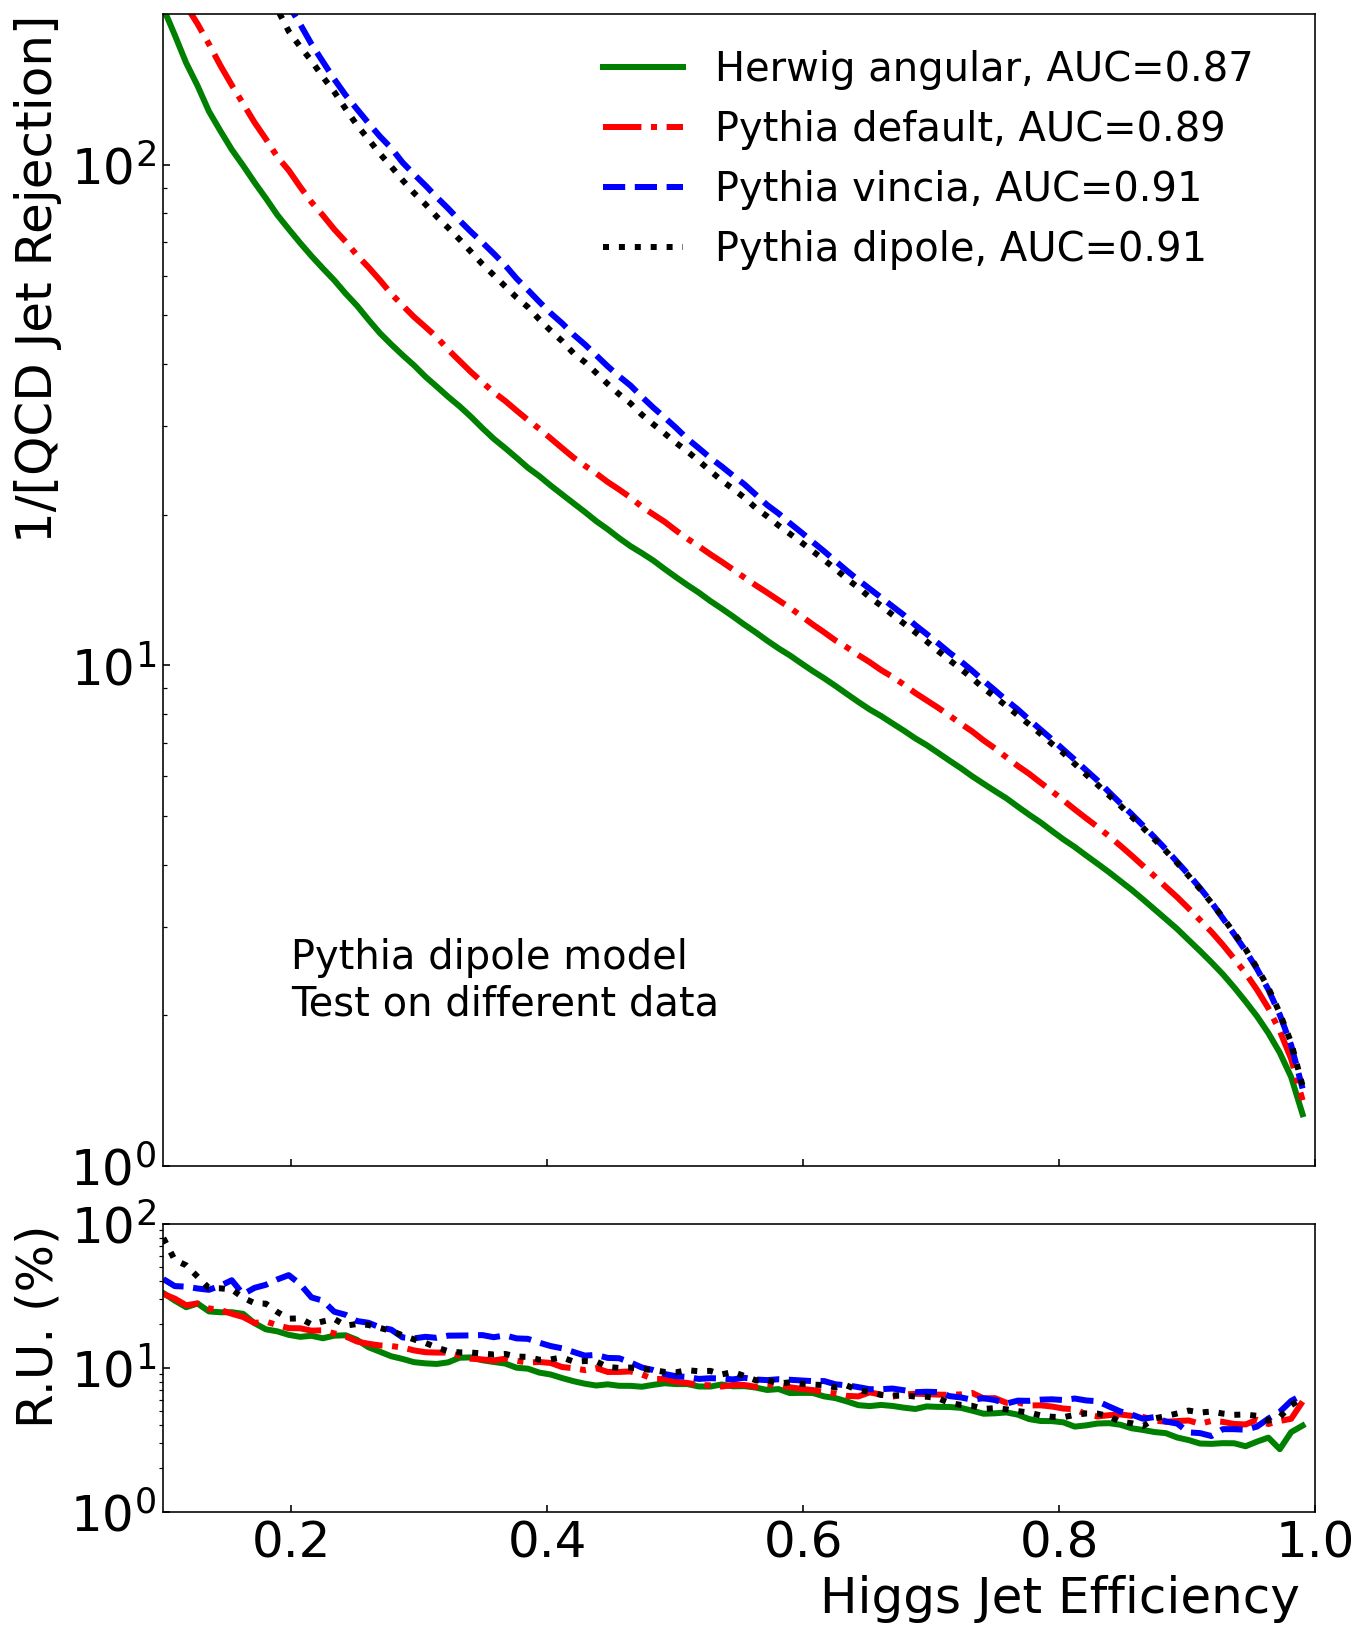

INFO:root:

INFO:root:



CPU times: user 2.02 s, sys: 38.8 ms, total: 2.06 s
Wall time: 2.06 s


In [527]:
%%time
fix_model_or_fix_data = 0 # 0:fix model, 1:fix data


title = ["Herwig angular", "Pythia default", "Pythia vincia", "Pythia dipole"]

colors = ["green","red","blue","black"]
linestyle = ["-","-.","--",":"]


data_train = {
        "herwig_ang_train" : {"index":0, "data":0},
        "pythia_def_train" : {"index":1, "data":0},
        "pythia_vin_train" : {"index":2, "data":0},
        "pythia_dip_train" : {"index":3, "data":0},
        }  

CNN_Model_A1 = {
#       "herwig_ang" : 0,
#       "pythia_def" : 1, 
#       "pythia_vin" : 2, 
      "pythia_dip" : 3, 
    }

# fig, ax = plt.subplots(1,1, figsize=(8,8)) 
fig = plt.figure(figsize=(8,8))
for i, model in enumerate(CNN_Model_A1): 
    logging.info("CNN Model: {}".format(model))

    for j, traindata in enumerate(data_train):

        Performance_Frame = {
        "AUC" : np.zeros(50),
        "max_sig" : [0],
        "r05" : [0],
        "time": [0]
        }

        
        filepath = "./"+str(model)+"_KFold/CNN_"+str(model)+"_Performance_Table_to_"+str(traindata)+"_"+str(pt_min)+str(pt_max)+".h5"
        if os.path.exists(filepath):
            hf_read = h5py.File(filepath, 'r')
            
            FalsePositiveFull_inverse_array = []
            for k in range(50):
                prediction_test =  hf_read.get("prediction_test_"+str(k))
                discriminator_test =  hf_read.get("discriminator_test_"+str(k))
            

                Performance_Frame["AUC"][k] = metrics.roc_auc_score(hf_read.get("target_val_"+str(k)), discriminator_test)
                FalsePositiveFull, TruePositiveFull = hf_read.get("FalsePositiveFull_"+str(k))[:], hf_read.get("TruePositiveFull_"+str(k))[:]
                
#                 """
#                 Remove Duplicated Index: Method 1
#                 """
#                 TruePositiveFull_ = [(element+TruePositiveFull[i+1])/2 for i, element in enumerate(TruePositiveFull) if i+1 < len(TruePositiveFull)]
#                 FalsePositiveFull_ = [(element+FalsePositiveFull[i+1])/2 for i, element in enumerate(FalsePositiveFull) if i+1 < len(FalsePositiveFull)]
#                 TruePositiveFull_ = [(element+TruePositiveFull_[i+1])/2 for i, element in enumerate(TruePositiveFull_) if i+1 < len(TruePositiveFull_)]
#                 FalsePositiveFull_ = [(element+FalsePositiveFull_[i+1])/2 for i, element in enumerate(FalsePositiveFull_) if i+1 < len(FalsePositiveFull_)]
#                 TruePositiveFull_ = [(element+TruePositiveFull_[i+1])/2 for i, element in enumerate(TruePositiveFull_) if i+1 < len(TruePositiveFull_)]
#                 FalsePositiveFull_ = [(element+FalsePositiveFull_[i+1])/2 for i, element in enumerate(FalsePositiveFull_) if i+1 < len(FalsePositiveFull_)]
                
                """
                Remove Duplicated Index: Method 2
                """
                without_duplicat_index = [i for i, element in enumerate(TruePositiveFull) if i+1 < len(TruePositiveFull) if element!= TruePositiveFull[i+1] ]
                TruePositiveFull_ = TruePositiveFull[without_duplicat_index]
                FalsePositiveFull_ = FalsePositiveFull[without_duplicat_index]
                
                
                curve_fit = interpolate.interp1d(TruePositiveFull_, FalsePositiveFull_,kind='previous')
                plot_range = np.linspace(0.1,0.99,101)
                FalsePositiveFull_inverse_array.append(1./curve_fit(plot_range))
            
#             tmp = np.where(FalsePositiveFull != 0)
#             Performance_Frame["max_sig"][0] = max(TruePositiveFull[tmp]/np.sqrt(FalsePositiveFull[tmp])) 
#             tmp = np.where(TruePositiveFull >= 0.5)
#             Performance_Frame["r05"][0]= 1./FalsePositiveFull[tmp[0][0]]

#             Performance_Frame["time"][0] = (time.time() - ticks_1)/60.

            FalsePositiveFull_inverse_array = np.array(FalsePositiveFull_inverse_array)
            FalsePositiveFull_inverse_average = np.average(FalsePositiveFull_inverse_array, axis=0)
            FalsePositiveFull_inverse_std = np.std(FalsePositiveFull_inverse_array, axis=0)
    
    
            if fix_model_or_fix_data == 0:
                plot_index = j
            elif fix_model_or_fix_data == 1:
                plot_index = i
            else:
                raise ValueError("Pleas check model fixed or data fixed !!")

            if np.average(Performance_Frame["AUC"]) >= 0.7:
                frame1=fig.add_axes((0,0.3,1,1))
                frame1.plot(
                         plot_range, FalsePositiveFull_inverse_average,
                         linewidth = 3,
                         ls=linestyle[plot_index], 
                         color=colors[plot_index], 
#                          label="%s, AUC=%.2f $\pm$ %.3f" % (title[plot_index],np.average(Performance_Frame["AUC"]),np.std(Performance_Frame["AUC"]))
                         label="%s, AUC=%.2f" % (title[plot_index],np.average(Performance_Frame["AUC"]))
                        )
                
                frame2=fig.add_axes((0,0, 1, 0.25)) 
                frame2.plot(
                         plot_range, FalsePositiveFull_inverse_std/FalsePositiveFull_inverse_average*100,
                         linewidth = 3,
                         ls=linestyle[plot_index], 
                         color=colors[plot_index], 
                           )
            else:
                pass


        else:
            raise ValueError("Pleas check model path !!")

#             plt.xlim((0.1,1))
#             plt.ylim((1, 2E+2))
#             plt.yscale("log")
#             plt.show()

#     logging.info("There are {} events for each test.".format(len(hf_read.get("target_val_0"))))
#     logging.info("{} CNN models apply on {} is finished!!".format(model,traindata))
    logging.info("END===========================================END")
    logging.info("\n")

            
            
            
    
    if fix_model_or_fix_data == 0:
        frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
        # frame1.tick_params(axis='x', labelsize=25, rotation=45)
        # frame1.xaxis.set_major_locator(MaxNLocator(10)) 
        frame1.tick_params(which='both', labelsize=25, direction = "in")
        frame1.tick_params(axis='y', labelsize=25, direction = "in")
        frame1.set_xlim((0.1,1))
        frame1.set_ylim((1, 2E+2))
        frame1.set_yscale("log")
        frame1.set_ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1) 
        frame1.legend(bbox_to_anchor=(0.35, 1),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1)
        frame1.text(0.2,2,"%s model \nTest on different data" % title[CNN_Model_A1[model]], fontsize=20)

        frame2.tick_params(axis='x', labelsize=25, direction = "in") 
        frame2.tick_params(axis='y', labelsize=25, direction = "in")
    #     frame2.tick_params(which='major', labelsize=25, direction = "in")
    #     frame2.yaxis.get_ticklocs(minor=True)
        frame2.yaxis.set_minor_locator(MultipleLocator(10)) 
        frame2.set_xlim((0.1,1)) #Change CNN_Model_A1
        frame2.set_ylim((1, 1E+2)) #Change CNN_Model_A1
        frame2.set_yscale("log") #Change CNN_Model_A1
        frame2.set_xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) 
        frame2.set_ylabel('R.U. (%)', fontsize=25,horizontalalignment='right',y=1)
        plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/"+str(model)+"_model_change_data_CNN.pdf", transparent=True, bbox_inches='tight')
        plt.show() #Change data_train



        logging.info("\n")
        logging.info("\n")
    else:
        pass
    
    
if fix_model_or_fix_data == 1:
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    # frame1.tick_params(axis='x', labelsize=25, rotation=45)
    # frame1.xaxis.set_major_locator(MaxNLocator(10)) 
    frame1.tick_params(which='both', labelsize=25, direction = "in")
    frame1.tick_params(axis='y', labelsize=25, direction = "in")
    frame1.set_xlim((0.1,1))
    frame1.set_ylim((1, 2E+2))
    frame1.set_yscale("log")
    frame1.set_ylabel('1/[QCD Jet Rejection]', fontsize=25,horizontalalignment='right',y=1) 
    frame1.legend(bbox_to_anchor=(0.7, 0.3),ncol=1,fontsize=20, edgecolor = "w",fancybox=False, framealpha=0) #bbox_to_anchor=(0.7, 0.1)
    frame1.text(0.4,100,"CNN Test on \n%s sample" % title[data_train[traindata]["index"]], fontsize=25)
    
    frame2.tick_params(axis='x', labelsize=25, direction = "in") 
    frame2.tick_params(axis='y', labelsize=25, direction = "in")
    frame2.tick_params(which='both', labelsize=25, direction = "in")
#     frame2.yaxis.get_ticklocs(minor=True)
    frame2.yaxis.set_minor_locator(MultipleLocator(10)) 
    frame2.set_xlim((0.1,1)) #Change CNN_Model_A1
    frame2.set_ylim((1, 5E+1)) #Change CNN_Model_A1
    frame2.set_yscale("log") #Change CNN_Model_A1
    frame2.set_xlabel('Higgs Jet Efficiency ', fontsize=25,horizontalalignment='right',x=1) 
    frame2.set_ylabel('R.U. (%)', fontsize=25,horizontalalignment='right',y=1) 
#     frame2.grid()
    plt.savefig("/dicos_ui_home/alanchung/Universality_Boosetd_Higgs/Notebook/Plots/change_model_"+str(traindata)[:10]+"_data_CNN.pdf", transparent=True, bbox_inches='tight')
    plt.show() 
    
else:
        pass


